In [60]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score





In [61]:
feature_weights = {
    'Age': 0.45,
    'NumOfProducts': 0.29,
    'IsActiveMember': 0.21,
    'Balance': 0.16
}

In [77]:
# Define the KNN class
class KNN:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric


    def fit(self, X, y):
        self.X_train = X
        self.y_train = y


    def predict(self, X):
        predictions = []

        for x in X:
            distances = self.compute_distance(self.X_train, x)
            indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[indices]
            probability = np.mean(k_nearest_labels)
            predictions.append(probability)

        return np.array(predictions)

    def compute_distance(self, X1, X2):
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((X1 - X2)**2, axis=1))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(X1 - X2), axis=1)
        else:
            raise ValueError('Invalid distance metric')
        
    
        


        

In [73]:
# Define data preprocessing function
def preprocess_data(train_path, test_path, missing_values = 'drop'):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)


    if missing_values == 'drop':
        train_data = train_data.dropna()
        test_data = test_data.dropna()
    elif missing_values == 'mean':
        train_data = train_data.fillna(train_data.select_dtypes(include=[np.number]).mean())
        test_data = test_data.fillna(train_data.select_dtypes(include=[np.number]).mean())
    elif missing_values == 'mode':
        train_data = train_data.fillna(train_data.select_dtypes(include=[object]).mode().iloc[0])
        test_data = test_data.fillna(train_data.select_dtypes(include=[object]).mode().iloc[0])
    else:
        raise ValueError('Invalid missing value strategy')
            
    # One-hot encode categorical features
    # train_data = pd.get_dummies(train_data, drop_first=True)
    # test_data = pd.get_dummies(test_data, drop_first=True)

    # train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

    selected_features = ['Age', 'NumOfProducts', 'IsActiveMember', 'Balance']

    # Select only the 'age' and 'balance' features
    X_train = train_data[selected_features].values
    X_test = test_data[selected_features].values


    # Scale Features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # Scale training features
    X_test = scaler.transform(X_test)  # Scale test features
    

    y_train = train_data.iloc[:, -1].values
    y_test = test_data.iloc[:, -1].values

    return X_train, X_test, y_train, y_test



In [74]:
# Define cross-validation function
def cross_validate(X, y, knn, n_splits=5):
    kf = KFold(n_splits=n_splits)
    scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        knn.fit(X_train, y_train)
        probabilities = knn.predict(X_test)

        binary_predictions = (probabilities >= 0.5).astype(int)

        
        # Compute ROC AUC score
        score = roc_auc_score(y_test, probabilities)
        scores.append(score)

    return scores

In [75]:
def tune_knn(X, y, param_grid, n_splits=5):
    knn = KNN()  # Initialize KNN with default parameters
    
    best_score = 0
    best_params = None
    
    for params in param_grid:
        knn.k = params['k']
        knn.distance_metric = params['distance_metric']
        scores = cross_validate(X, y, knn, n_splits=n_splits)
        mean_score = np.mean(scores)
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            print(f'Found new best params: {best_params} with score: {best_score}')
        else:
            print(f'Params {params} did not improve performance')
    
    return best_params, best_score


# Define the parameter grid
param_grid = [
    {'k': k, 'distance_metric': metric}
    for k in [50,70,90]  # Example range for k
    for metric in ['euclidean', 'manhattan']
]

In [76]:
# Load and preprocess data
X_train, X_test, y_train, y_test = preprocess_data('train.csv', 'test.csv')

# Perform hyperparameter tuning
best_params, best_score = tune_knn(X_train, y_train, param_grid, n_splits=5)

if best_params:
    print("Best parameters:", best_params)
else:
    print("No best parameters found.")
    

# Create and evaluate model with the best parameters
knn = KNN()
knn.k = best_params['k']
knn.distance_metric = best_params['distance_metric']

# Perform cross-validation with the best parameters
cv_scores = cross_validate(X_train, y_train, knn, n_splits=5)

print("Cross-validation scores with best parameters:", cv_scores)

# Train the model on the entire training data
knn.fit(X_train, y_train)

# Make predictions on the test data
test_predictions = knn.predict(X_test)

# Save predictions to a CSV file
pd.DataFrame({'id': pd.read_csv('test.csv')['id'], 'Exited': test_predictions}).to_csv('submissions.csv', index=False)

/var/folders/dk/vyk6_yxx6rx4y27dlhv_cvq80000gn/T/ipykernel_40196/529227811.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  weight_vector = np.array([feature_weights[feature] for feature in feature_weights.keys() if feature in x])


TypeError: Axis must be specified when shapes of a and weights differ.

In [45]:
def evaluate_model(X, y, knn, n_splits=5):
    kf = KFold(n_splits=n_splits)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        knn.fit(X_train, y_train)
        probabilities = knn.predict(X_test)
        binary_predictions = (probabilities >= 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test, binary_predictions)
        precision = precision_score(y_test, binary_predictions)
        recall = recall_score(y_test, binary_predictions)
        f1 = f1_score(y_test, binary_predictions)
        roc_auc = roc_auc_score(y_test, probabilities)

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

    print("Cross-validated scores of :")
    print(f"Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
    print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
    print(f"Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
    print(f"F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"ROC AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")
    

In [46]:
X_train, X_test, y_train, y_test = preprocess_data('train.csv', 'test.csv')

for param in param_grid:
    knn.k = param['k']
    knn.distance_metric = param['distance_metric']
    print(f"Cross-validated scores with k={param['k']} and distance metric={param['distance_metric']}:")
    evaluate_model(X_train, y_train, knn, n_splits=5)


Cross-validated scores with k=10 and distance metric=euclidean:
Cross-validated scores of :
Accuracy: 0.8814 ± 0.0054
Precision: 0.7300 ± 0.0225
Recall: 0.6584 ± 0.0178
F1: 0.6919 ± 0.0071
ROC AUC: 0.8870 ± 0.0022
Cross-validated scores with k=10 and distance metric=manhattan:
Cross-validated scores of :
Accuracy: 0.8811 ± 0.0033
Precision: 0.7314 ± 0.0160
Recall: 0.6526 ± 0.0197
F1: 0.6893 ± 0.0073
ROC AUC: 0.8897 ± 0.0059
Cross-validated scores with k=30 and distance metric=euclidean:
Cross-validated scores of :
Accuracy: 0.8882 ± 0.0032
Precision: 0.7715 ± 0.0129
Recall: 0.6360 ± 0.0149
F1: 0.6970 ± 0.0047
ROC AUC: 0.9096 ± 0.0019
Cross-validated scores with k=30 and distance metric=manhattan:
Cross-validated scores of :
Accuracy: 0.8880 ± 0.0046
Precision: 0.7748 ± 0.0097
Recall: 0.6293 ± 0.0149
F1: 0.6944 ± 0.0089
ROC AUC: 0.9100 ± 0.0030
Cross-validated scores with k=50 and distance metric=euclidean:
Cross-validated scores of :
Accuracy: 0.8880 ± 0.0052
Precision: 0.7856 ± 0.0148

Feature: Age, Weight: 0.45
Feature: NumOfProducts, Weight: 0.29
Feature: Geography_Germany, Weight: 0.25
Feature: IsActiveMember, Weight: 0.21
Feature: Gender_Male, Weight: 0.17
Feature: Balance, Weight: 0.16


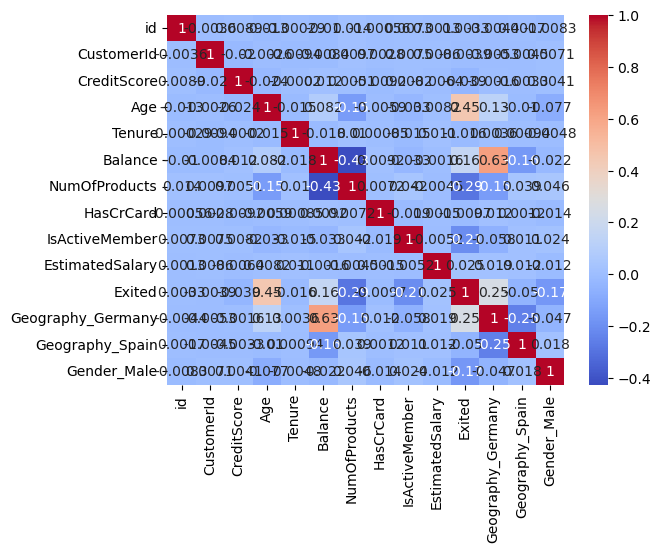

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt


# Assuming df is your DataFrame
df = pd.read_csv('train.csv')
target_variable = 'Exited'

df = df.drop(columns=['Surname'])

df = pd.get_dummies(df, drop_first=True)

# non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
# df_numeric = df.drop(columns=non_numeric_cols)
corr_matrix = df.corr()
correlations = corr_matrix[target_variable].abs().sort_values(ascending=False)
threshold = 0.1
selected_features = correlations[correlations > threshold].index.tolist()

selected_features.remove(target_variable)

weights = correlations[selected_features].values

for feature, weight in zip(selected_features, weights):
    print(f"Feature: {feature}, Weight: {weight:.2f}")





sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()